In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Google Drive where you have saved the unzipped 'analysis' folder containing the 'functions' folder.
# e.g. 'Controlled\ Methane\ Release\ Stanford-Kairos\ Oct\ 2019/Elementa\ Submission/analysis'
folder_name = 'analysis/'
root_path = 'Controlled\ Methane\ Release\ Stanford-Kairos\ Oct\ 2019/Elementa\ Submission/'+folder_name

assert root_path is not None, "[!] Enter directory."

%cd drive/My\ Drive
%cp -r $root_path ../../
%cd ../../

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive
/content


# setup

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

# auto-reload external Python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# ignore some warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
# directory for storing graphs generated
graph_dir = folder_name+'graphs_SI/'

from datetime import date
today = date.today()
fdate = date.today().strftime('%m%d%Y')    # append the data today when exporting the graphs

# load data

In [0]:
data = pd.read_excel('analysis/Stanford-Kairos Controlled Release.xlsx',sheet_name='DATA',skiprows=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 37 columns):
 #   Column                                             Non-Null Count  Dtype         
---  ------                                             --------------  -----         
 0   date                                               234 non-null    datetime64[ns]
 1   minute                                             234 non-null    object        
 2   Pass                                               234 non-null    int64         
 3   closest_plume_quantification_mcfdmph               191 non-null    float64       
 4   closest_plume_length_m                             191 non-null    float64       
 5   sonic_windGust_mph                                 182 non-null    float64       
 6   WS_windGust_logged_mph                             234 non-null    int64         
 7   sonic_windSpeed_mph                                182 non-null    float64       
 8   WS_windSpeed_mph    

## Adjust methane release rate based on gas composition

Methane release rate is methane_vol% * total natural gas release rate

The average methane content from November 4- December 5 was 93.5% in the two BTU areas closest to Yolo/Sacramento where the gas was filled (downstream of the filling stations). The BTU areas are H09 and X01.
https://www.pge.com/pipeline/operations/gas_quality/index.page
BTU areas come from a map from PG&E's 2017 filing of FERC Form 2. The map is not in their most recent 2018 filing.

In [0]:
from analysis.functions.data_processing import convert_to_CH4_rate
CH4_vol_fraction = 0.935
data = convert_to_CH4_rate(data,CH4_vol_fraction)

## Convert from US/Imperial to Metric

In [0]:
from analysis.functions.data_processing import convert_to_metric

# CH4_density[kg/mcf] under 20 deg C and 1 atm
CH4_density = 0.714 * 28.317    # (0.714 kg/m3) * (28.317 m3/mcf)  ref: http://www.energy-sea.gov.il/English-Site/Pages/Data%20and%20Maps/calc.aspx

data = convert_to_metric(data,CH4_density)

## Exclude invalid data points
Based on sensitivity cases (base case presented in the manuscript) and wind speed data. Note that the ultrasonic anemometer was not available on 10/8/2019. Consequently, the Kairos quantification in (kg/h)/(m/s) cannot be multiplied with the concurrent wind speed measured by the ultrasonic anemometer on that day; hence reducing the number of valid data points if ultrasonic anemoemter is chosen.

In [0]:
from analysis.functions.data_processing import data_selection
WS_data = data_selection(data,'Base','WS_windGust_logged_mps')
sonic_data = data_selection(data,'Base','WS_windGust_logged_mps')
darksky_data = data_selection(data,'Base','darksky_windGust_mps')

# detection threshold
Detection threshold in (kg/d)/(m/s) is determined with binned data

In [2]:
from analysis.functions.min_detection import detection_rate_by_bin

n_bins=6
threshold=24

ModuleNotFoundError: ignored

## cup wind meter 

In [3]:
detection, detection_prob=detection_rate_by_bin(WS_data,n_bins,threshold)
# detection_prob

NameError: ignored

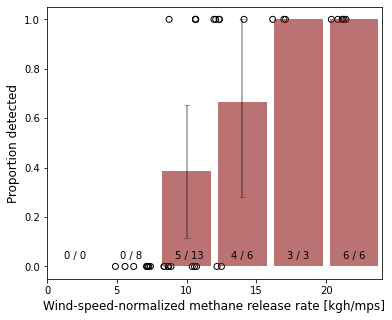

In [0]:
fig,ax = plt.subplots(figsize = [6,5])
for i in range(n_bins):
  ax.annotate('%d / %d' %(detection_prob.n_detected[i],detection_prob.n_data_points[i]),
              [detection_prob.bin_median[i]-0.8,0.03],fontsize=10)

# for plotting purpose, we don't want a small hypen indicating zero uncertainty interval
detection_prob.detection_prob_two_sigma_lower[detection_prob.detection_prob_two_sigma_lower==0]=np.nan  
detection_prob.detection_prob_two_sigma_upper[detection_prob.detection_prob_two_sigma_upper==0]=np.nan

# plot the bars and the detection points
ax.bar(detection_prob.bin_median,detection_prob.detection_prob_mean,
       yerr=[detection_prob.detection_prob_two_sigma_lower,detection_prob.detection_prob_two_sigma_upper],
       error_kw=dict(lw=2, capsize=3, capthick=1,alpha=0.3),
       width=threshold/n_bins-0.5,alpha=0.6,color='#8c1515',ecolor='black', capsize=2)
ax.scatter(detection.release_rate_wind_normalized,np.multiply(detection.detected,1),
           edgecolor="black",facecolors='none')
ax.set_xlabel('Wind-speed-normalized methane release rate [kgh/mps]',fontsize=12)
ax.set_ylabel('Proportion detected',fontsize=12)
ax.set_ylim([-0.05,1.05])
ax.set_xlim([0,threshold]) 
# ax.set_xticks([0,4,8,12,16,20,24])
# ax.set_xticks([0,3,6,9,12,15,18,21,24])

# save fig
plt.savefig(graph_dir+'KairosDetectionThresholdCup'+fdate+'.pdf',format='pdf')

In [1]:
detection

NameError: ignored

## ultrasonic anemometer

In [0]:
detection, detection_prob=detection_rate_by_bin(sonic_data,n_bins,threshold)
# detection_prob

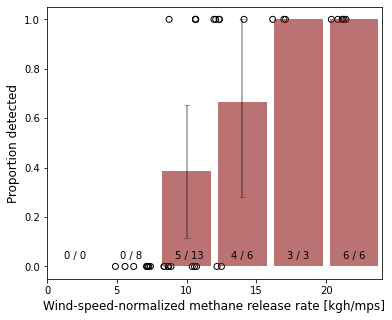

In [0]:
fig,ax = plt.subplots(figsize = [6,5])
for i in range(n_bins):
  ax.annotate('%d / %d' %(detection_prob.n_detected[i],detection_prob.n_data_points[i]),
              [detection_prob.bin_median[i]-0.8,0.03],fontsize=10)

# for plotting purpose, we don't want a small hypen indicating zero uncertainty interval
detection_prob.detection_prob_two_sigma_lower[detection_prob.detection_prob_two_sigma_lower==0]=np.nan  
detection_prob.detection_prob_two_sigma_upper[detection_prob.detection_prob_two_sigma_upper==0]=np.nan

# plot the bars and the detection points
ax.bar(detection_prob.bin_median,detection_prob.detection_prob_mean,
       yerr=[detection_prob.detection_prob_two_sigma_lower,detection_prob.detection_prob_two_sigma_upper],
       error_kw=dict(lw=2, capsize=3, capthick=1,alpha=0.3),
       width=threshold/n_bins-0.5,alpha=0.6,color='#8c1515',ecolor='black', capsize=2)
ax.scatter(detection.release_rate_wind_normalized,np.multiply(detection.detected,1),
           edgecolor="black",facecolors='none')
ax.set_xlabel('Wind-speed-normalized methane release rate [kgh/mps]',fontsize=12)
ax.set_ylabel('Proportion detected',fontsize=12)
ax.set_ylim([-0.05,1.05])
ax.set_xlim([0,threshold]) 
# ax.set_xticks([0,4,8,12,16,20,24])
# ax.set_xticks([0,3,6,9,12,15,18,21,24])

# save fig
plt.savefig(graph_dir+'KairosDetectionThresholdUltrasonic'+fdate+'.pdf',format='pdf')

## Darksky

In [0]:
detection, detection_prob=detection_rate_by_bin(darksky_data,n_bins,threshold)
# detection_prob

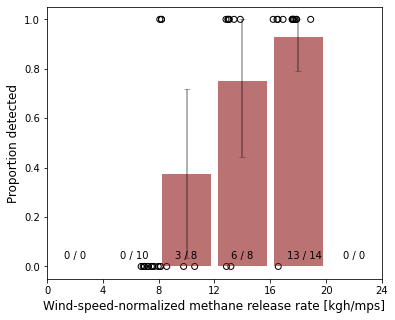

In [0]:
fig,ax = plt.subplots(figsize = [6,5])
for i in range(n_bins):
  ax.annotate('%d / %d' %(detection_prob.n_detected[i],detection_prob.n_data_points[i]),
              [detection_prob.bin_median[i]-0.8,0.03],fontsize=10)

# for plotting purpose, we don't want a small hypen indicating zero uncertainty interval
detection_prob.detection_prob_two_sigma_lower[detection_prob.detection_prob_two_sigma_lower==0]=np.nan  
detection_prob.detection_prob_two_sigma_upper[detection_prob.detection_prob_two_sigma_upper==0]=np.nan

# plot the bars and the detection points
ax.bar(detection_prob.bin_median,detection_prob.detection_prob_mean,
       yerr=[detection_prob.detection_prob_two_sigma_lower,detection_prob.detection_prob_two_sigma_upper],
       error_kw=dict(lw=2, capsize=3, capthick=1,alpha=0.3),
       width=threshold/n_bins-0.5,alpha=0.6,color='#8c1515',ecolor='black', capsize=2)
ax.scatter(detection.release_rate_wind_normalized,np.multiply(detection.detected,1),
           edgecolor="black",facecolors='none')
ax.set_xlabel('Wind-speed-normalized methane release rate [kgh/mps]',fontsize=12)
ax.set_ylabel('Proportion detected',fontsize=12)
ax.set_ylim([-0.05,1.05])
ax.set_xlim([0,threshold]) 
ax.set_xticks([0,4,8,12,16,20,24])
# ax.set_xticks([0,3,6,9,12,15,18,21,24])

# save fig
plt.savefig(graph_dir+'KairosDetectionThresholdUltrasonic'+fdate+'.pdf',format='pdf')

# parity chart

## Ordinary Linear Regression

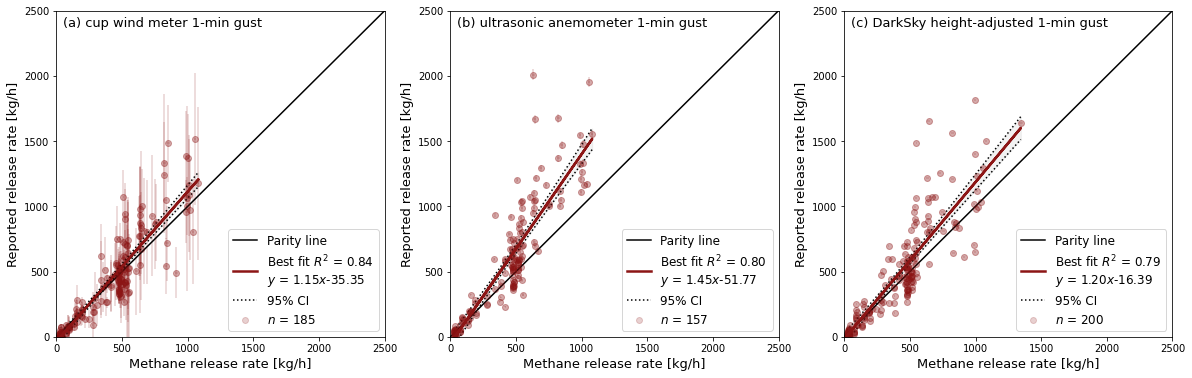

In [0]:
from analysis.functions.parity import linreg_results

################################ INPUTS ######################################
plot_interval = ['confidence']     # choose from ['confidence','prediction']
case = 'Base'      # choose from ['Loose','Base','Strict'] case-sensitive

################################ Figure setup #################################
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[20,6])
ax1.annotate('(a) cup wind meter 1-min gust', [50,2380],fontsize=13)
ax2.annotate('(b) ultrasonic anemometer 1-min gust', [50,2380],fontsize=13)
ax3.annotate('(c) DarkSky height-adjusted 1-min gust', [50,2380],fontsize=13)
ax1.set_xlabel('Methane release rate [kg/h]',fontsize=13),ax1.set_ylabel('Reported release rate [kg/h]',fontsize=13)
ax2.set_xlabel('Methane release rate [kg/h]',fontsize=13),ax2.set_ylabel('Reported release rate [kg/h]',fontsize=13)
ax3.set_xlabel('Methane release rate [kg/h]',fontsize=13),ax3.set_ylabel('Reported release rate [kg/h]',fontsize=13)
ax1.set_xlim([0,2500]),ax1.set_ylim([0,2500])
ax2.set_xlim([0,2500]),ax2.set_ylim([0,2500])
ax3.set_xlim([0,2500]),ax3.set_ylim([0,2500])

x_lim = np.array([0,3000])
y_lim = np.array([0,3000])
ax1.plot(x_lim,y_lim,color='black',label = 'Parity line')     # parity line
ax2.plot(x_lim,y_lim,color='black',label = 'Parity line')     # parity line
ax3.plot(x_lim,y_lim,color='black',label = 'Parity line')     # parity line

################################# cup wind meter ####################

plot_data = data_selection(data,case,'WS_windGust_logged_mps')
x = plot_data.CH4_release_kgh.values
y = plot_data.closest_plume_quantification_kgh.fillna(0).values
n,pearson_corr,slope,intercept,r_value,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results(x,y)

ax1.scatter(x,y,color='#8c1515',alpha = 0.2,label='$n$ = %d' %(n))
ax1.errorbar(x, y, xerr=plot_data.CH4_release_meter_error_kgh,
             yerr=[plot_data.quantification_lower_error_kgh,plot_data.quantification_upper_error_kgh],
             fmt='o',color='#8c1515',ecolor='#8c1515', elinewidth=1.5, capsize=0,alpha=0.2);
ax1.plot(x,y_pred,'-',color='#8c1515',linewidth=2.5,
        label = 'Best fit $R^{2}$ = %0.2f \n$y$ = %0.2f$x$%0.2f' % (r_value**2,slope,intercept))
if 'confidence' in plot_interval:
    ax1.plot(np.sort(x),upper_CI,':',color='black', label='95% CI')
    ax1.plot(np.sort(x),lower_CI,':',color='black')
    ax1.fill_between(np.sort(x), lower_CI, upper_CI, color='black', alpha=0.05)
if 'prediction' in plot_interval:
    ax1.plot(np.sort(x),upper_PI,':',color='#8c1515', label='95% PI')
    ax1.plot(np.sort(x),lower_PI,':',color='#8c1515')
    ax1.fill_between(np.sort(x), lower_PI, upper_PI, color='black', alpha=0.05)
ax1.legend(loc="lower right",fontsize=12)

################################# ultrasonic anemometer ####################

plot_data = data_selection(data,case,'sonic_windGust_mps')
x = plot_data.CH4_release_kgh.values
y = plot_data.closest_plume_quantification_kgh.fillna(0).values
n,pearson_corr,slope,intercept,r_value,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results(x,y)

ax2.scatter(x,y,color='#8c1515',alpha = 0.2,label='$n$ = %d' %(n))
ax2.errorbar(x, y, xerr=plot_data.CH4_release_meter_error_kgh,
             yerr=[plot_data.quantification_lower_error_kgh,plot_data.quantification_upper_error_kgh],
             fmt='o',color='#8c1515',ecolor='#8c1515', elinewidth=1.5, capsize=0,alpha=0.2);
ax2.plot(x,y_pred,'-',color='#8c1515',linewidth=2.5,
        label = 'Best fit $R^{2}$ = %0.2f \n$y$ = %0.2f$x$%0.2f' % (r_value**2,slope,intercept))
if 'confidence' in plot_interval:
    ax2.plot(np.sort(x),upper_CI,':',color='black', label='95% CI')
    ax2.plot(np.sort(x),lower_CI,':',color='black')
    ax2.fill_between(np.sort(x), lower_CI, upper_CI, color='black', alpha=0.05)
if 'prediction' in plot_interval:
    ax2.plot(np.sort(x),upper_PI,':',color='#8c1515', label='95% PI')
    ax2.plot(np.sort(x),lower_PI,':',color='#8c1515')
    ax2.fill_between(np.sort(x), lower_PI, upper_PI, color='black', alpha=0.05)
ax2.legend(loc="lower right",fontsize=12)

################################# DarkSky ####################

plot_data = data_selection(data,case,'darksky_windGust_mps')
x = plot_data.CH4_release_kgh.values
y = plot_data.closest_plume_quantification_kgh.fillna(0).values
n,pearson_corr,slope,intercept,r_value,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results(x,y)

ax3.scatter(x,y,color='#8c1515',alpha = 0.2,label='$n$ = %d' %(n))
ax3.errorbar(x, y, xerr=plot_data.CH4_release_meter_error_kgh,
             yerr=[plot_data.quantification_lower_error_kgh,plot_data.quantification_upper_error_kgh],
             fmt='o',color='#8c1515',ecolor='#8c1515', elinewidth=1.5, capsize=0,alpha=0.2);
ax3.plot(x,y_pred,'-',color='#8c1515',linewidth=2.5,
        label = 'Best fit $R^{2}$ = %0.2f \n$y$ = %0.2f$x$%0.2f' % (r_value**2,slope,intercept))
if 'confidence' in plot_interval:
    ax3.plot(np.sort(x),upper_CI,':',color='black', label='95% CI')
    ax3.plot(np.sort(x),lower_CI,':',color='black')
    ax3.fill_between(np.sort(x), lower_CI, upper_CI, color='black', alpha=0.05)
if 'prediction' in plot_interval:
    ax3.plot(np.sort(x),upper_PI,':',color='#8c1515', label='95% PI')
    ax3.plot(np.sort(x),lower_PI,':',color='#8c1515')
    ax3.fill_between(np.sort(x), lower_PI, upper_PI, color='black', alpha=0.05)
ax3.legend(loc="lower right",fontsize=12)

# save fig
plt.savefig(graph_dir+'KairosDetectionParity'+fdate+'.pdf',format='pdf')

## force zero intercept

### wind gust

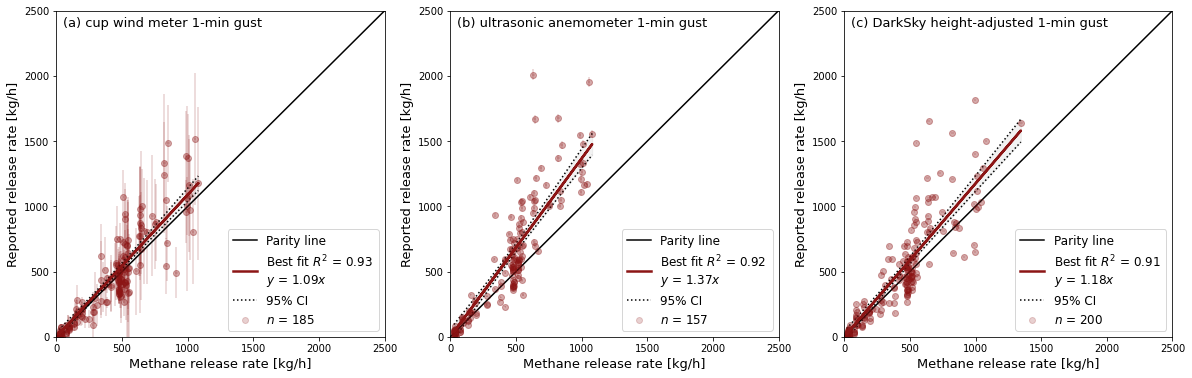

In [0]:
from analysis.functions.parity import linreg_results_no_intercept

################################ INPUTS ######################################
plot_interval = ['confidence']     # choose from ['confidence','prediction']
case = 'Base'      # choose from ['Loose','Base','Strict'] case-sensitive

################################ Figure setup #################################
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[20,6])
ax1.annotate('(a) cup wind meter 1-min gust', [50,2380],fontsize=13)
ax2.annotate('(b) ultrasonic anemometer 1-min gust', [50,2380],fontsize=13)
ax3.annotate('(c) DarkSky height-adjusted 1-min gust', [50,2380],fontsize=13)
ax1.set_xlabel('Methane release rate [kg/h]',fontsize=13),ax1.set_ylabel('Reported release rate [kg/h]',fontsize=13)
ax2.set_xlabel('Methane release rate [kg/h]',fontsize=13),ax2.set_ylabel('Reported release rate [kg/h]',fontsize=13)
ax3.set_xlabel('Methane release rate [kg/h]',fontsize=13),ax3.set_ylabel('Reported release rate [kg/h]',fontsize=13)
ax1.set_xlim([0,2500]),ax1.set_ylim([0,2500])
ax2.set_xlim([0,2500]),ax2.set_ylim([0,2500])
ax3.set_xlim([0,2500]),ax3.set_ylim([0,2500])

x_lim = np.array([0,3000])
y_lim = np.array([0,3000])
ax1.plot(x_lim,y_lim,color='black',label = 'Parity line')     # parity line
ax2.plot(x_lim,y_lim,color='black',label = 'Parity line')     # parity line
ax3.plot(x_lim,y_lim,color='black',label = 'Parity line')     # parity line

################################# cup wind meter ####################

plot_data = data_selection(data,case,'WS_windGust_logged_mps')
x = plot_data.CH4_release_kgh.values
y = plot_data.closest_plume_quantification_kgh.fillna(0).values
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)

ax1.scatter(x,y,color='#8c1515',alpha = 0.2,label='$n$ = %d' %(n))
ax1.errorbar(x, y, xerr=plot_data.CH4_release_meter_error_kgh,
             yerr=[plot_data.quantification_lower_error_kgh,plot_data.quantification_upper_error_kgh],
             fmt='o',color='#8c1515',ecolor='#8c1515', elinewidth=1.5, capsize=0,alpha=0.2);
ax1.plot(x,y_pred,'-',color='#8c1515',linewidth=2.5,
        label = 'Best fit $R^{2}$ = %0.2f \n$y$ = %0.2f$x$' % (r_squared,slope))
if 'confidence' in plot_interval:
    ax1.plot(np.sort(x),upper_CI,':',color='black', label='95% CI')
    ax1.plot(np.sort(x),lower_CI,':',color='black')
    ax1.fill_between(np.sort(x), lower_CI, upper_CI, color='black', alpha=0.05)
if 'prediction' in plot_interval:
    ax1.plot(np.sort(x),upper_PI,':',color='#8c1515', label='95% PI')
    ax1.plot(np.sort(x),lower_PI,':',color='#8c1515')
    ax1.fill_between(np.sort(x), lower_PI, upper_PI, color='black', alpha=0.05)
ax1.legend(loc="lower right",fontsize=12)

################################# ultrasonic anemometer ####################

plot_data = data_selection(data,case,'sonic_windGust_mps')
x = plot_data.CH4_release_kgh.values
y = plot_data.closest_plume_quantification_kgh.fillna(0).values
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)

ax2.scatter(x,y,color='#8c1515',alpha = 0.2,label='$n$ = %d' %(n))
ax2.errorbar(x, y, xerr=plot_data.CH4_release_meter_error_kgh,
             yerr=[plot_data.quantification_lower_error_kgh,plot_data.quantification_upper_error_kgh],
             fmt='o',color='#8c1515',ecolor='#8c1515', elinewidth=1.5, capsize=0,alpha=0.2);
ax2.plot(x,y_pred,'-',color='#8c1515',linewidth=2.5,
        label = 'Best fit $R^{2}$ = %0.2f \n$y$ = %0.2f$x$' % (r_squared,slope))
if 'confidence' in plot_interval:
    ax2.plot(np.sort(x),upper_CI,':',color='black', label='95% CI')
    ax2.plot(np.sort(x),lower_CI,':',color='black')
    ax2.fill_between(np.sort(x), lower_CI, upper_CI, color='black', alpha=0.05)
if 'prediction' in plot_interval:
    ax2.plot(np.sort(x),upper_PI,':',color='#8c1515', label='95% PI')
    ax2.plot(np.sort(x),lower_PI,':',color='#8c1515')
    ax2.fill_between(np.sort(x), lower_PI, upper_PI, color='black', alpha=0.05)
ax2.legend(loc="lower right",fontsize=12)

################################# DarkSky ####################

plot_data = data_selection(data,case,'darksky_windGust_mps')
x = plot_data.CH4_release_kgh.values
y = plot_data.closest_plume_quantification_kgh.fillna(0).values
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)

ax3.scatter(x,y,color='#8c1515',alpha = 0.2,label='$n$ = %d' %(n))
ax3.errorbar(x, y, xerr=plot_data.CH4_release_meter_error_kgh,
             yerr=[plot_data.quantification_lower_error_kgh,plot_data.quantification_upper_error_kgh],
             fmt='o',color='#8c1515',ecolor='#8c1515', elinewidth=1.5, capsize=0,alpha=0.2);
ax3.plot(x,y_pred,'-',color='#8c1515',linewidth=2.5,
        label = 'Best fit $R^{2}$ = %0.2f \n$y$ = %0.2f$x$' % (r_squared,slope))
if 'confidence' in plot_interval:
    ax3.plot(np.sort(x),upper_CI,':',color='black', label='95% CI')
    ax3.plot(np.sort(x),lower_CI,':',color='black')
    ax3.fill_between(np.sort(x), lower_CI, upper_CI, color='black', alpha=0.05)
if 'prediction' in plot_interval:
    ax3.plot(np.sort(x),upper_PI,':',color='#8c1515', label='95% PI')
    ax3.plot(np.sort(x),lower_PI,':',color='#8c1515')
    ax3.fill_between(np.sort(x), lower_PI, upper_PI, color='black', alpha=0.05)
ax3.legend(loc="lower right",fontsize=12)

# save fig
# plt.savefig(graph_dir+'KairosDetectionParityZeroIntercept'+fdate+'.pdf',format='pdf')

### wind avg

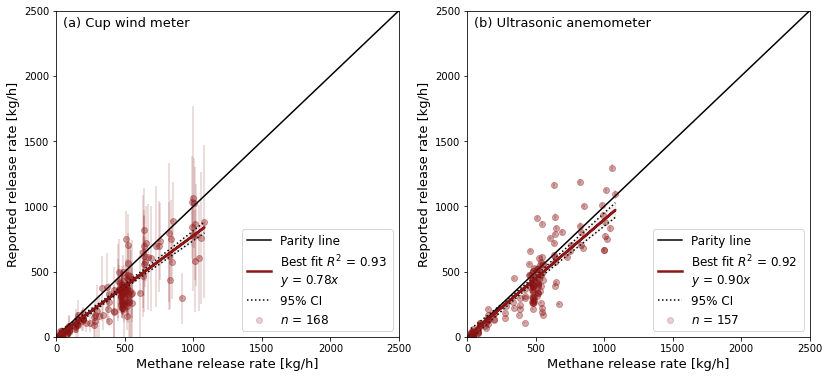

In [0]:
from analysis.functions.parity import linreg_results_no_intercept

################################ INPUTS ######################################
plot_interval = ['confidence']     # choose from ['confidence','prediction']
case = 'Base'      # choose from ['Loose','Base','Strict'] case-sensitive

################################ Figure setup #################################
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[13.5,6])
ax1.annotate('(a) Cup wind meter', [50,2380],fontsize=13)
ax2.annotate('(b) Ultrasonic anemometer', [50,2380],fontsize=13)
ax1.set_xlabel('Methane release rate [kg/h]',fontsize=13),ax1.set_ylabel('Reported release rate [kg/h]',fontsize=13)
ax2.set_xlabel('Methane release rate [kg/h]',fontsize=13),ax2.set_ylabel('Reported release rate [kg/h]',fontsize=13)
ax1.set_xlim([0,2500]),ax1.set_ylim([0,2500]),ax2.set_xlim([0,2500]),ax2.set_ylim([0,2500])

x_lim = np.array([0,3000])
y_lim = np.array([0,3000])
ax1.plot(x_lim,y_lim,color='black',label = 'Parity line')     # parity line
ax2.plot(x_lim,y_lim,color='black',label = 'Parity line')     # parity line

################################# cup wind meter ####################

plot_data = data_selection(data,case,'WS_windSpeed_mps')
x = plot_data.CH4_release_kgh.values
y = plot_data.closest_plume_quantification_kgh.fillna(0).values
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)

ax1.scatter(x,y,color='#8c1515',alpha = 0.2,label='$n$ = %d' %(n))
ax1.errorbar(x, y, xerr=plot_data.CH4_release_meter_error_kgh,
             yerr=[plot_data.quantification_lower_error_kgh,plot_data.quantification_upper_error_kgh],
             fmt='o',color='#8c1515',ecolor='#8c1515', elinewidth=1.5, capsize=0,alpha=0.2);
ax1.plot(x,y_pred,'-',color='#8c1515',linewidth=2.5,
        label = 'Best fit $R^{2}$ = %0.2f \n$y$ = %0.2f$x$' % (r_squared,slope))
if 'confidence' in plot_interval:
    ax1.plot(np.sort(x),upper_CI,':',color='black', label='95% CI')
    ax1.plot(np.sort(x),lower_CI,':',color='black')
    ax1.fill_between(np.sort(x), lower_CI, upper_CI, color='black', alpha=0.05)
if 'prediction' in plot_interval:
    ax1.plot(np.sort(x),upper_PI,':',color='#8c1515', label='95% PI')
    ax1.plot(np.sort(x),lower_PI,':',color='#8c1515')
    ax1.fill_between(np.sort(x), lower_PI, upper_PI, color='black', alpha=0.05)
ax1.legend(loc="lower right",fontsize=12)

################################# ultrasonic anemometer ####################

plot_data = data_selection(data,case,'sonic_windSpeed_mps')
x = plot_data.CH4_release_kgh.values
y = plot_data.closest_plume_quantification_kgh.fillna(0).values
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)

ax2.scatter(x,y,color='#8c1515',alpha = 0.2,label='$n$ = %d' %(n))
ax2.errorbar(x, y, xerr=plot_data.CH4_release_meter_error_kgh,
             yerr=[plot_data.quantification_lower_error_kgh,plot_data.quantification_upper_error_kgh],
             fmt='o',color='#8c1515',ecolor='#8c1515', elinewidth=1.5, capsize=0,alpha=0.2);
ax2.plot(x,y_pred,'-',color='#8c1515',linewidth=2.5,
        label = 'Best fit $R^{2}$ = %0.2f \n$y$ = %0.2f$x$' % (r_squared,slope))
if 'confidence' in plot_interval:
    ax2.plot(np.sort(x),upper_CI,':',color='black', label='95% CI')
    ax2.plot(np.sort(x),lower_CI,':',color='black')
    ax2.fill_between(np.sort(x), lower_CI, upper_CI, color='black', alpha=0.05)
if 'prediction' in plot_interval:
    ax2.plot(np.sort(x),upper_PI,':',color='#8c1515', label='95% PI')
    ax2.plot(np.sort(x),lower_PI,':',color='#8c1515')
    ax2.fill_between(np.sort(x), lower_PI, upper_PI, color='black', alpha=0.05)
ax2.legend(loc="lower right",fontsize=12)

# save fig
# plt.savefig(graph_dir+'KairosDetectionParityZeroIntercept'+fdate+'.pdf',format='pdf')

# Stationary percent residual

## parity inverted

### wind gust

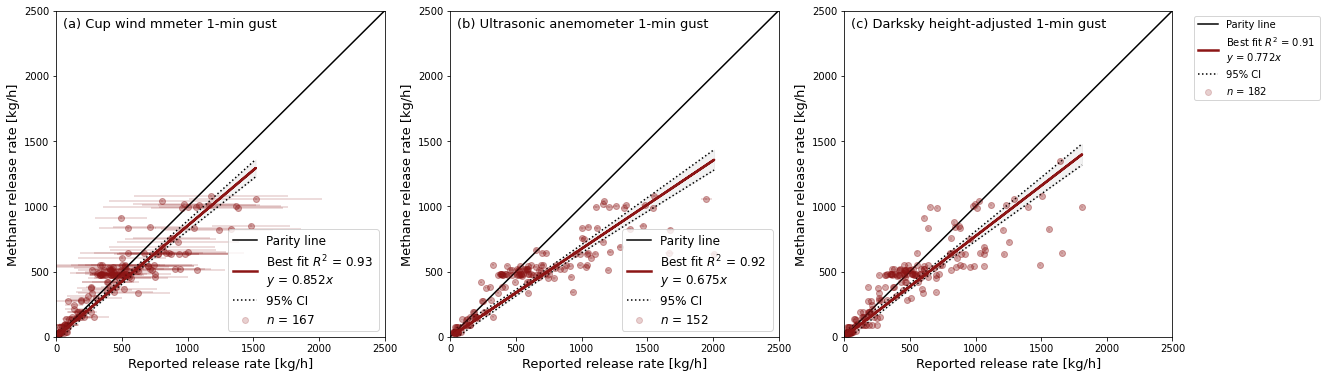

In [0]:
################################ INPUTS ######################################
plot_interval = ['confidence']     # choose from ['confidence','prediction']
case = 'Base'      # choose from ['Loose','Base','Strict'] case-sensitive

################################ Figure setup #################################
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[20,6])
ax1.annotate('(a) Cup wind mmeter 1-min gust', [50,2370],fontsize=13)
ax2.annotate('(b) Ultrasonic anemometer 1-min gust',[50,2370],fontsize=13)
ax3.annotate('(c) Darksky height-adjusted 1-min gust',[50,2370],fontsize=13)
ax1.set_ylabel('Methane release rate [kg/h]',fontsize=13),ax1.set_xlabel('Reported release rate [kg/h]',fontsize=13)
ax2.set_ylabel('Methane release rate [kg/h]',fontsize=13),ax2.set_xlabel('Reported release rate [kg/h]',fontsize=13)
ax3.set_ylabel('Methane release rate [kg/h]',fontsize=13),ax3.set_xlabel('Reported release rate [kg/h]',fontsize=13)
lim = [0,2500]
ax1.set_xlim(lim),ax1.set_ylim(lim)
ax2.set_xlim(lim),ax2.set_ylim(lim)
ax3.set_xlim(lim),ax3.set_ylim(lim)

x_lim = np.array([0,3000])
y_lim = np.array([0,3000])
ax1.plot(x_lim,y_lim,color='black',label = 'Parity line')     # parity line
ax2.plot(x_lim,y_lim,color='black',label = 'Parity line')     # parity line
ax3.plot(x_lim,y_lim,color='black',label = 'Parity line')     # parity line

################################# cup wind meter ####################

plot_data = data_selection(data,case,'WS_windGust_logged_mps')
plot_data = plot_data[plot_data.closest_plume_quantification_kgh!=0]
plot_data = plot_data[~np.isnan(plot_data.closest_plume_quantification_kgh)]
y = plot_data.CH4_release_kgh.values
x = plot_data.closest_plume_quantification_kgh.values
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)

n,slope_orig,r_squared_orig,y_lim,x_pred,_,_,_,_,_,_ = linreg_results_no_intercept(y,x)


ax1.scatter(x,y,color='#8c1515',alpha = 0.2,label='$n$ = %d' %(n))
ax1.errorbar(x, y, yerr=plot_data.CH4_release_meter_error_kgh,
             xerr=[plot_data.quantification_lower_error_kgh,plot_data.quantification_upper_error_kgh],
             fmt='o',color='#8c1515',ecolor='#8c1515', elinewidth=1.5, capsize=0,alpha=0.2);
ax1.plot(x,y_pred,'-',color='#8c1515',linewidth=2.5,
        label = 'Best fit $R^{2}$ = %0.2f \n$y$ = %0.3f$x$' % (r_squared,slope))
if 'confidence' in plot_interval:
    ax1.plot(np.sort(x),upper_CI,':',color='black', label='95% CI')
    ax1.plot(np.sort(x),lower_CI,':',color='black')
    ax1.fill_between(np.sort(x), lower_CI, upper_CI, color='black', alpha=0.05)
if 'prediction' in plot_interval:
    ax1.plot(np.sort(x),upper_PI,':',color='#8c1515', label='95% PI')
    ax1.plot(np.sort(x),lower_PI,':',color='#8c1515')
    ax1.fill_between(np.sort(x), lower_PI, upper_PI, color='black', alpha=0.05)


# add the lines from regressing reported rate on release rate
# ax2.plot(x_pred,x_pred/slope_orig,'--',color='#8c1515',linewidth=2.5,
#         label = 'Best fit $R^{2}$ = %0.2f \n$x$ = %0.3f$y$' % (r_squared,slope_orig))


ax1.legend(loc="lower right",fontsize=12)

################################# ultrasonic anemometer ####################

plot_data = data_selection(data,case,'sonic_windGust_mps')
plot_data = plot_data[plot_data.closest_plume_quantification_kgh!=0]
plot_data = plot_data[~np.isnan(plot_data.closest_plume_quantification_kgh)]
y = plot_data.CH4_release_kgh.values
x = plot_data.closest_plume_quantification_kgh.values
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)

n,slope_orig,r_squared_orig,y_lim,x_pred,_,_,_,_,_,_ = linreg_results_no_intercept(y,x)

ax2.scatter(x,y,color='#8c1515',alpha = 0.2,label='$n$ = %d' %(n))
ax2.errorbar(x, y, yerr=plot_data.CH4_release_meter_error_kgh,
             xerr=[plot_data.quantification_lower_error_kgh,plot_data.quantification_upper_error_kgh],
             fmt='o',color='#8c1515',ecolor='#8c1515', elinewidth=1.5, capsize=0,alpha=0.2);
ax2.plot(x,y_pred,'-',color='#8c1515',linewidth=2.5,
        label = 'Best fit $R^{2}$ = %0.2f \n$y$ = %0.3f$x$' % (r_squared,slope))
if 'confidence' in plot_interval:
    ax2.plot(np.sort(x),upper_CI,':',color='black', label='95% CI')
    ax2.plot(np.sort(x),lower_CI,':',color='black')
    ax2.fill_between(np.sort(x), lower_CI, upper_CI, color='black', alpha=0.05)
if 'prediction' in plot_interval:
    ax2.plot(np.sort(x),upper_PI,':',color='#8c1515', label='95% PI')
    ax2.plot(np.sort(x),lower_PI,':',color='#8c1515')
    ax2.fill_between(np.sort(x), lower_PI, upper_PI, color='black', alpha=0.05)


# add the lines from regressing reported rate on release rate
# ax2.plot(x_pred,x_pred/slope_orig,'--',color='#8c1515',linewidth=2.5,
#         label = 'Best fit $R^{2}$ = %0.2f \n$x$ = %0.3f$y$' % (r_squared,slope_orig))

ax2.legend(loc="lower right",fontsize=12)


################################# DarkSky ####################

plot_data = data_selection(data,case,'darksky_windGust_mps')
plot_data = plot_data[plot_data.closest_plume_quantification_kgh!=0]
plot_data = plot_data[~np.isnan(plot_data.closest_plume_quantification_kgh)]
y = plot_data.CH4_release_kgh.values
x = plot_data.closest_plume_quantification_kgh.values
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)

n,slope_orig,r_squared_orig,y_lim,x_pred,_,_,_,_,_,_ = linreg_results_no_intercept(y,x)

ax3.scatter(x,y,color='#8c1515',alpha = 0.2,label='$n$ = %d' %(n))
ax3.errorbar(x, y, yerr=plot_data.CH4_release_meter_error_kgh,
             xerr=[plot_data.quantification_lower_error_kgh,plot_data.quantification_upper_error_kgh],
             fmt='o',color='#8c1515',ecolor='#8c1515', elinewidth=1.5, capsize=0,alpha=0.2);
ax3.plot(x,y_pred,'-',color='#8c1515',linewidth=2.5,
        label = 'Best fit $R^{2}$ = %0.2f \n$y$ = %0.3f$x$' % (r_squared,slope))
if 'confidence' in plot_interval:
    ax3.plot(np.sort(x),upper_CI,':',color='black', label='95% CI')
    ax3.plot(np.sort(x),lower_CI,':',color='black')
    ax3.fill_between(np.sort(x), lower_CI, upper_CI, color='black', alpha=0.05)
if 'prediction' in plot_interval:
    ax3.plot(np.sort(x),upper_PI,':',color='#8c1515', label='95% PI')
    ax3.plot(np.sort(x),lower_PI,':',color='#8c1515')
    ax3.fill_between(np.sort(x), lower_PI, upper_PI, color='black', alpha=0.05)


# add the lines from regressing reported rate on release rate
# ax3.plot(x_pred,x_pred/slope_orig,'--',color='#8c1515',linewidth=2.5,
#         label = 'Best fit $R^{2}$ = %0.2f \n$x$ = %0.3f$y$' % (r_squared,slope_orig))

# ax3.legend(loc="lower right",fontsize=12)
ax3.legend(bbox_to_anchor=(1.05, 1))

plt.show()

# save fig
# plt.savefig(graph_dir+'InvertedParityZeroIntercept'+fdate+'.pdf',format='pdf')

In [0]:
import statsmodels.api as sm
model = sm.OLS(x,y)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                              1807.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):                    6.44e-86
Time:                        15:47:54   Log-Likelihood:                         -1025.0
No. Observations:                 152   AIC:                                      2052.
Df Residuals:                     151   BIC:                                      2055.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3668      0.032     42.509      0.000       1.303       1.430
==============================================================================
Omnibus:                       81.909   Durbin-Watson:                   1.713
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              424.790
Skew:                           1.940   Prob(JB):                     5.73e-93
Kurtosis:                      10.213   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### wind avg

1.0201050664389757


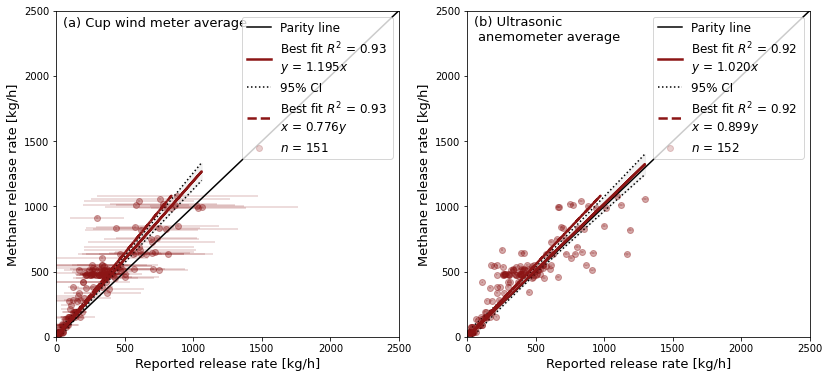

In [0]:
################################ INPUTS ######################################
plot_interval = ['confidence']     # choose from ['confidence','prediction']
case = 'Base'      # choose from ['Loose','Base','Strict'] case-sensitive

################################ Figure setup #################################
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[13.5,6])
ax1.annotate('(a) Cup wind meter average', [50,2380],fontsize=13)
ax2.annotate('(b) Ultrasonic\n anemometer average', [50,2270],fontsize=13)
ax1.set_ylabel('Methane release rate [kg/h]',fontsize=13),ax1.set_xlabel('Reported release rate [kg/h]',fontsize=13)
ax2.set_ylabel('Methane release rate [kg/h]',fontsize=13),ax2.set_xlabel('Reported release rate [kg/h]',fontsize=13)
lim = [0,2500]
ax1.set_xlim(lim),ax1.set_ylim(lim),ax2.set_xlim(lim),ax2.set_ylim(lim)

x_lim = np.array([0,3000])
y_lim = np.array([0,3000])
ax1.plot(x_lim,y_lim,color='black',label = 'Parity line')     # parity line
ax2.plot(x_lim,y_lim,color='black',label = 'Parity line')     # parity line

################################# cup wind meter ####################

plot_data = data_selection(data,case,'WS_windSpeed_mps')
plot_data = plot_data[plot_data.closest_plume_quantification_kgh!=0]
plot_data = plot_data[~np.isnan(plot_data.closest_plume_quantification_kgh)]
y = plot_data.CH4_release_kgh.values
x = plot_data.closest_plume_quantification_kgh.values
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)

n,slope_orig,r_squared_orig,y_lim,x_pred,_,_,_,_,_,_ = linreg_results_no_intercept(y,x)



ax1.scatter(x,y,color='#8c1515',alpha = 0.2,label='$n$ = %d' %(n))
ax1.errorbar(x, y, yerr=plot_data.CH4_release_meter_error_kgh,
             xerr=[plot_data.quantification_lower_error_kgh,plot_data.quantification_upper_error_kgh],
             fmt='o',color='#8c1515',ecolor='#8c1515', elinewidth=1.5, capsize=0,alpha=0.2);
ax1.plot(x,y_pred,'-',color='#8c1515',linewidth=2.5,
        label = 'Best fit $R^{2}$ = %0.2f \n$y$ = %0.3f$x$' % (r_squared,slope))
if 'confidence' in plot_interval:
    ax1.plot(np.sort(x),upper_CI,':',color='black', label='95% CI')
    ax1.plot(np.sort(x),lower_CI,':',color='black')
    ax1.fill_between(np.sort(x), lower_CI, upper_CI, color='black', alpha=0.05)
if 'prediction' in plot_interval:
    ax1.plot(np.sort(x),upper_PI,':',color='#8c1515', label='95% PI')
    ax1.plot(np.sort(x),lower_PI,':',color='#8c1515')
    ax1.fill_between(np.sort(x), lower_PI, upper_PI, color='black', alpha=0.05)


# add the lines from the 
ax1.plot(x_pred,x_pred/slope_orig,'--',color='#8c1515',linewidth=2.5,
        label = 'Best fit $R^{2}$ = %0.2f \n$x$ = %0.3f$y$' % (r_squared,slope_orig))


ax1.legend(loc="upper right",fontsize=12)

################################# ultrasonic anemometer ####################

plot_data = data_selection(data,case,'sonic_windSpeed_mps')
plot_data = plot_data[plot_data.closest_plume_quantification_kgh!=0]
plot_data = plot_data[~np.isnan(plot_data.closest_plume_quantification_kgh)]
y = plot_data.CH4_release_kgh.values
x = plot_data.closest_plume_quantification_kgh.values
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)
print(slope)

n,slope_orig,r_squared_orig,y_lim,x_pred,_,_,_,_,_,_ = linreg_results_no_intercept(y,x)

ax2.scatter(x,y,color='#8c1515',alpha = 0.2,label='$n$ = %d' %(n))
ax2.errorbar(x, y, yerr=plot_data.CH4_release_meter_error_kgh,
             xerr=[plot_data.quantification_lower_error_kgh,plot_data.quantification_upper_error_kgh],
             fmt='o',color='#8c1515',ecolor='#8c1515', elinewidth=1.5, capsize=0,alpha=0.2);
ax2.plot(x,y_pred,'-',color='#8c1515',linewidth=2.5,
        label = 'Best fit $R^{2}$ = %0.2f \n$y$ = %0.3f$x$' % (r_squared,slope))
if 'confidence' in plot_interval:
    ax2.plot(np.sort(x),upper_CI,':',color='black', label='95% CI')
    ax2.plot(np.sort(x),lower_CI,':',color='black')
    ax2.fill_between(np.sort(x), lower_CI, upper_CI, color='black', alpha=0.05)
if 'prediction' in plot_interval:
    ax2.plot(np.sort(x),upper_PI,':',color='#8c1515', label='95% PI')
    ax2.plot(np.sort(x),lower_PI,':',color='#8c1515')
    ax2.fill_between(np.sort(x), lower_PI, upper_PI, color='black', alpha=0.05)


# add the lines from the 
ax2.plot(x_pred,x_pred/slope_orig,'--',color='#8c1515',linewidth=2.5,
        label = 'Best fit $R^{2}$ = %0.2f \n$x$ = %0.3f$y$' % (r_squared,slope_orig))

ax2.legend(loc="upper right",fontsize=12)
plt.show()

# save fig
# plt.savefig(graph_dir+'InvertedParityZeroIntercept'+fdate+'.pdf',format='pdf')

## stationarity: LOESS curve

### wind gust

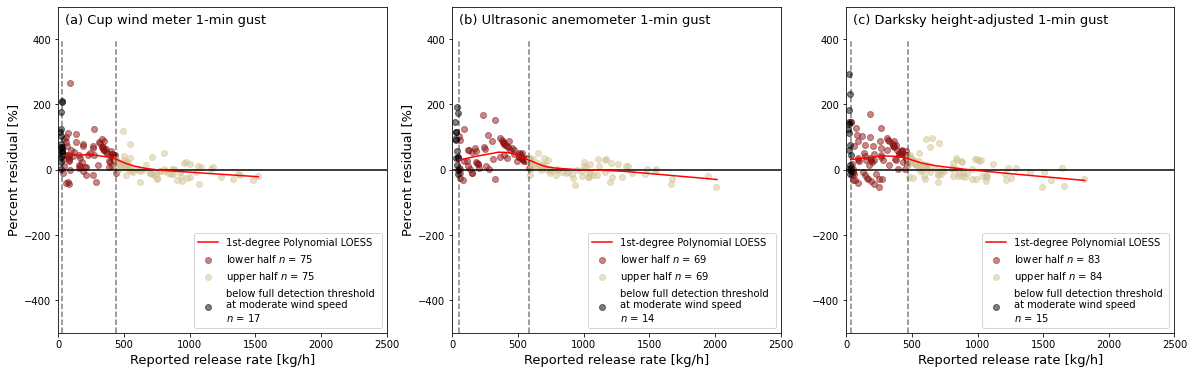

In [0]:
from analysis.functions.LOESS import *

full_detection_limit = 16   # kgh/mps methane over which 100% is detected

fig, ([ax1,ax2,ax3]) = plt.subplots(1,3,figsize=[20,6])
ax1.set_xlabel('Reported release rate [kg/h]',fontsize=13),ax1.set_ylabel('Percent residual [%]',fontsize=13)
ax2.set_xlabel('Reported release rate [kg/h]',fontsize=13),ax2.set_ylabel('Percent residual [%]',fontsize=13)
ax3.set_xlabel('Reported release rate [kg/h]',fontsize=13),ax2.set_ylabel('Percent residual [%]',fontsize=13)
ax1.set_xlim([0,2500]),ax1.set_ylim([-500,500])
ax2.set_xlim([0,2500]),ax2.set_ylim([-500,500])
ax3.set_xlim([0,2500]),ax3.set_ylim([-500,500])
x_lim = np.array([0,3000])
y_lim = np.array([0,0])
ax1.plot(x_lim,y_lim,color='black')
ax2.plot(x_lim,y_lim,color='black')
ax3.plot(x_lim,y_lim,color='black')
ax1.annotate('(a) Cup wind meter 1-min gust',[50,450],fontsize=13)
ax2.annotate('(b) Ultrasonic anemometer 1-min gust',[50,450],fontsize=13)
ax3.annotate('(c) Darksky height-adjusted 1-min gust',[50,450],fontsize=13)
# ax2.annotate('Ultrasonic gust percent residual',[50,450],fontsize=13)

################# cup wind meter #######################
plot_data = data_selection(data,'Base','WS_windGust_logged_mps')
plot_data = plot_data[plot_data.closest_plume_quantification_kgh!=0]
plot_data = plot_data[~np.isnan(plot_data.closest_plume_quantification_kgh)]
y = plot_data.CH4_release_kgh.values
x = plot_data.closest_plume_quantification_kgh.values
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)
y_pred = x*slope
percent_residual = residual/y_pred*100

x_leave_out = x[x<full_detection_limit*plot_data.WS_windGust_logged_mps.median()]
df = pd.DataFrame()
df['x'] = x[x>=full_detection_limit*plot_data.WS_windGust_logged_mps.median()]
df['y'] = percent_residual[x>=full_detection_limit*plot_data.WS_windGust_logged_mps.median()]

ax1.scatter(df.x[df.x<df.x.median()],df.y[df.x<df.x.median()],c='#8c1515',alpha = 0.5,label='lower half $n$ = %d' %df.x[df.x<df.x.median()].shape[0])
ax1.scatter(df.x[df.x>=df.x.median()],df.y[df.x>=df.x.median()],c = '#D2C295',alpha = 0.5,label='upper half $n$ = %d' %df.x[df.x>=df.x.median()].shape[0])
ax1.scatter(x_leave_out,percent_residual[x<full_detection_limit*plot_data.WS_windGust_logged_mps.median()],c='k',alpha = 0.5,label = "below full detection threshold \nat moderate wind speed\n$n$ = %d" %(len(x_leave_out)))

regsDF, evalDF = loess(df.x, df.y,alpha=0.6, poly_degree=1)
l_x  = evalDF['v'].values
l_y  = evalDF['g'].values
ax1.plot(l_x, l_y, color='#FF0000', label="1st-degree Polynomial LOESS")
ax1.legend(loc='lower right')
ax1.plot([np.max(x_leave_out),np.max(x_leave_out)],[-500,400],linestyle='--',color='k',alpha=0.5)
ax1.plot([np.min(df.x[df.x>=df.x.median()]),np.min(df.x[df.x>=df.x.median()])],[-500,400],linestyle='--',color='k',alpha=0.5)

############## ultrasonic anemometer ########################
plot_data = data_selection(data,'Base','sonic_windGust_mps')
plot_data = plot_data[plot_data.closest_plume_quantification_kgh!=0]
plot_data = plot_data[~np.isnan(plot_data.closest_plume_quantification_kgh)]
y = plot_data.CH4_release_kgh.values
x = plot_data.closest_plume_quantification_kgh.values
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)
y_pred = x*slope
percent_residual = residual/y_pred*100

x_leave_out = x[x<full_detection_limit*plot_data.sonic_windGust_mps.median()]
df = pd.DataFrame()
df['x'] = x[x>=full_detection_limit*plot_data.sonic_windGust_mps.median()]
df['y'] = percent_residual[x>=full_detection_limit*plot_data.sonic_windGust_mps.median()]

ax2.scatter(df.x[df.x<df.x.median()],df.y[df.x<df.x.median()],c='#8c1515',alpha = 0.5,label='lower half $n$ = %d' %df.x[df.x<df.x.median()].shape[0])
ax2.scatter(df.x[df.x>=df.x.median()],df.y[df.x>=df.x.median()],c = '#D2C295',alpha = 0.5,label='upper half $n$ = %d' %df.x[df.x>=df.x.median()].shape[0])
ax2.scatter(x_leave_out,percent_residual[x<full_detection_limit*plot_data.sonic_windGust_mps.median()],
            c='k',alpha = 0.5,label = "below full detection threshold \nat moderate wind speed\n$n$ = %d" %(len(x_leave_out)))

regsDF, evalDF = loess(df.x, df.y,alpha=0.6, poly_degree=1)
l_x  = evalDF['v'].values
l_y  = evalDF['g'].values
ax2.plot(l_x, l_y, color='#FF0000', label="1st-degree Polynomial LOESS")
ax2.legend(loc='lower right')
ax2.plot([np.min(df.x[df.x<df.x.median()]),np.min(df.x[df.x<df.x.median()])],[-500,400],linestyle='--',color='k',alpha=0.5)
ax2.plot([np.min(df.x[df.x>=df.x.median()]),np.min(df.x[df.x>=df.x.median()])],[-500,400],linestyle='--',color='k',alpha=0.5)


##############  darksky ########################
wind_to_use = 'darksky_windGust_mps'
plot_data = data_selection(data,'Base',wind_to_use)
plot_data = plot_data[plot_data.closest_plume_quantification_kgh!=0]
plot_data = plot_data[~np.isnan(plot_data.closest_plume_quantification_kgh)]
y = plot_data.CH4_release_kgh.values
x = plot_data.closest_plume_quantification_kgh.values
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)
y_pred = x*slope
percent_residual = residual/y_pred*100

x_leave_out = x[x<full_detection_limit*plot_data[wind_to_use].median()]
df = pd.DataFrame()
df['x'] = x[x>=full_detection_limit*plot_data[wind_to_use].median()]
df['y'] = percent_residual[x>=full_detection_limit*plot_data[wind_to_use].median()]

ax3.scatter(df.x[df.x<df.x.median()],df.y[df.x<df.x.median()],c='#8c1515',alpha = 0.5,label='lower half $n$ = %d' %df.x[df.x<df.x.median()].shape[0])
ax3.scatter(df.x[df.x>=df.x.median()],df.y[df.x>=df.x.median()],c = '#D2C295',alpha = 0.5,label='upper half $n$ = %d' %df.x[df.x>=df.x.median()].shape[0])
ax3.scatter(x_leave_out,percent_residual[x<full_detection_limit*plot_data[wind_to_use].median()],
            c='k',alpha = 0.5,label = "below full detection threshold \nat moderate wind speed\n$n$ = %d" %(len(x_leave_out)))

regsDF, evalDF = loess(df.x, df.y,alpha=0.6, poly_degree=1)
l_x  = evalDF['v'].values
l_y  = evalDF['g'].values
ax3.plot(l_x, l_y, color='#FF0000', label="1st-degree Polynomial LOESS")
ax3.legend(loc='lower right')
ax3.plot([np.min(df.x[df.x<df.x.median()]),np.min(df.x[df.x<df.x.median()])],[-500,400],linestyle='--',color='k',alpha=0.5)
ax3.plot([np.min(df.x[df.x>=df.x.median()]),np.min(df.x[df.x>=df.x.median()])],[-500,400],linestyle='--',color='k',alpha=0.5)

# save fig
# plt.savefig(graph_dir+'InvertedStationaryResidual'+fdate+'.pdf',format='pdf')

### wind avg

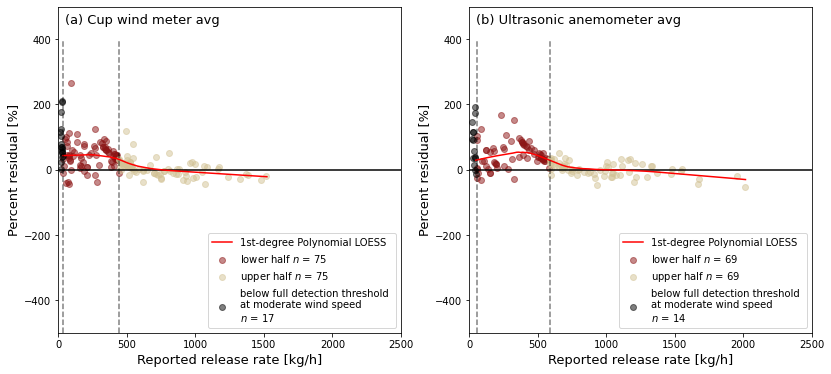

In [0]:
from analysis.functions.LOESS import *

full_detection_limit = 16   # kgh/mps methane over which 100% is detected

fig, ([ax1,ax2]) = plt.subplots(1,2,figsize=[13.5,6])
ax1.set_xlabel('Reported release rate [kg/h]',fontsize=13),ax1.set_ylabel('Percent residual [%]',fontsize=13)
ax2.set_xlabel('Reported release rate [kg/h]',fontsize=13),ax2.set_ylabel('Percent residual [%]',fontsize=13)
ax1.set_xlim([0,2500]),ax1.set_ylim([-500,500]),ax2.set_xlim([0,2500]),ax2.set_ylim([-500,500])
x_lim = np.array([0,3000])
y_lim = np.array([0,0])
ax1.plot(x_lim,y_lim,color='black')
ax2.plot(x_lim,y_lim,color='black')
ax1.annotate('(a) Cup wind meter avg',[50,450],fontsize=13)
ax2.annotate('(b) Ultrasonic anemometer avg',[50,450],fontsize=13)

################# cup wind meter #######################
plot_data = data_selection(data,'Base','WS_windGust_logged_mps')
plot_data = plot_data[plot_data.closest_plume_quantification_kgh!=0]
plot_data = plot_data[~np.isnan(plot_data.closest_plume_quantification_kgh)]
y = plot_data.CH4_release_kgh.values
x = plot_data.closest_plume_quantification_kgh.values
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)
y_pred = x*slope
percent_residual = residual/y_pred*100

x_leave_out = x[x<full_detection_limit*plot_data.WS_windGust_logged_mps.median()]
df = pd.DataFrame()
df['x'] = x[x>=full_detection_limit*plot_data.WS_windGust_logged_mps.median()]
df['y'] = percent_residual[x>=full_detection_limit*plot_data.WS_windGust_logged_mps.median()]

ax1.scatter(df.x[df.x<df.x.median()],df.y[df.x<df.x.median()],c='#8c1515',alpha = 0.5,label='lower half $n$ = %d' %df.x[df.x<df.x.median()].shape[0])
ax1.scatter(df.x[df.x>=df.x.median()],df.y[df.x>=df.x.median()],c = '#D2C295',alpha = 0.5,label='upper half $n$ = %d' %df.x[df.x>=df.x.median()].shape[0])
ax1.scatter(x_leave_out,percent_residual[x<full_detection_limit*plot_data.WS_windGust_logged_mps.median()],c='k',alpha = 0.5,label = "below full detection threshold \nat moderate wind speed\n$n$ = %d" %(len(x_leave_out)))

regsDF, evalDF = loess(df.x, df.y,alpha=0.6, poly_degree=1)
l_x  = evalDF['v'].values
l_y  = evalDF['g'].values
ax1.plot(l_x, l_y, color='#FF0000', label="1st-degree Polynomial LOESS")
ax1.legend(loc='lower right')
ax1.plot([np.max(x_leave_out),np.max(x_leave_out)],[-500,400],linestyle='--',color='k',alpha=0.5)
ax1.plot([np.min(df.x[df.x>=df.x.median()]),np.min(df.x[df.x>=df.x.median()])],[-500,400],linestyle='--',color='k',alpha=0.5)

############## ultrasonic anemometer ########################
plot_data = data_selection(data,'Base','sonic_windGust_mps')
plot_data = plot_data[plot_data.closest_plume_quantification_kgh!=0]
plot_data = plot_data[~np.isnan(plot_data.closest_plume_quantification_kgh)]
y = plot_data.CH4_release_kgh.values
x = plot_data.closest_plume_quantification_kgh.values
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)
y_pred = x*slope
percent_residual = residual/y_pred*100

x_leave_out = x[x<full_detection_limit*plot_data.sonic_windGust_mps.median()]
df = pd.DataFrame()
df['x'] = x[x>=full_detection_limit*plot_data.sonic_windGust_mps.median()]
df['y'] = percent_residual[x>=full_detection_limit*plot_data.sonic_windGust_mps.median()]

ax2.scatter(df.x[df.x<df.x.median()],df.y[df.x<df.x.median()],c='#8c1515',alpha = 0.5,label='lower half $n$ = %d' %df.x[df.x<df.x.median()].shape[0])
ax2.scatter(df.x[df.x>=df.x.median()],df.y[df.x>=df.x.median()],c = '#D2C295',alpha = 0.5,label='upper half $n$ = %d' %df.x[df.x>=df.x.median()].shape[0])
ax2.scatter(x_leave_out,percent_residual[x<full_detection_limit*plot_data.sonic_windGust_mps.median()],
            c='k',alpha = 0.5,label = "below full detection threshold \nat moderate wind speed\n$n$ = %d" %(len(x_leave_out)))

regsDF, evalDF = loess(df.x, df.y,alpha=0.6, poly_degree=1)
l_x  = evalDF['v'].values
l_y  = evalDF['g'].values
ax2.plot(l_x, l_y, color='#FF0000', label="1st-degree Polynomial LOESS")
ax2.legend(loc='lower right')
ax2.plot([np.min(df.x[df.x<df.x.median()]),np.min(df.x[df.x<df.x.median()])],[-500,400],linestyle='--',color='k',alpha=0.5)
ax2.plot([np.min(df.x[df.x>=df.x.median()]),np.min(df.x[df.x>=df.x.median()])],[-500,400],linestyle='--',color='k',alpha=0.5)

# save fig
# plt.savefig(graph_dir+'InvertedStationaryResidual'+fdate+'.pdf',format='pdf')

## fit residual 

### wind gust

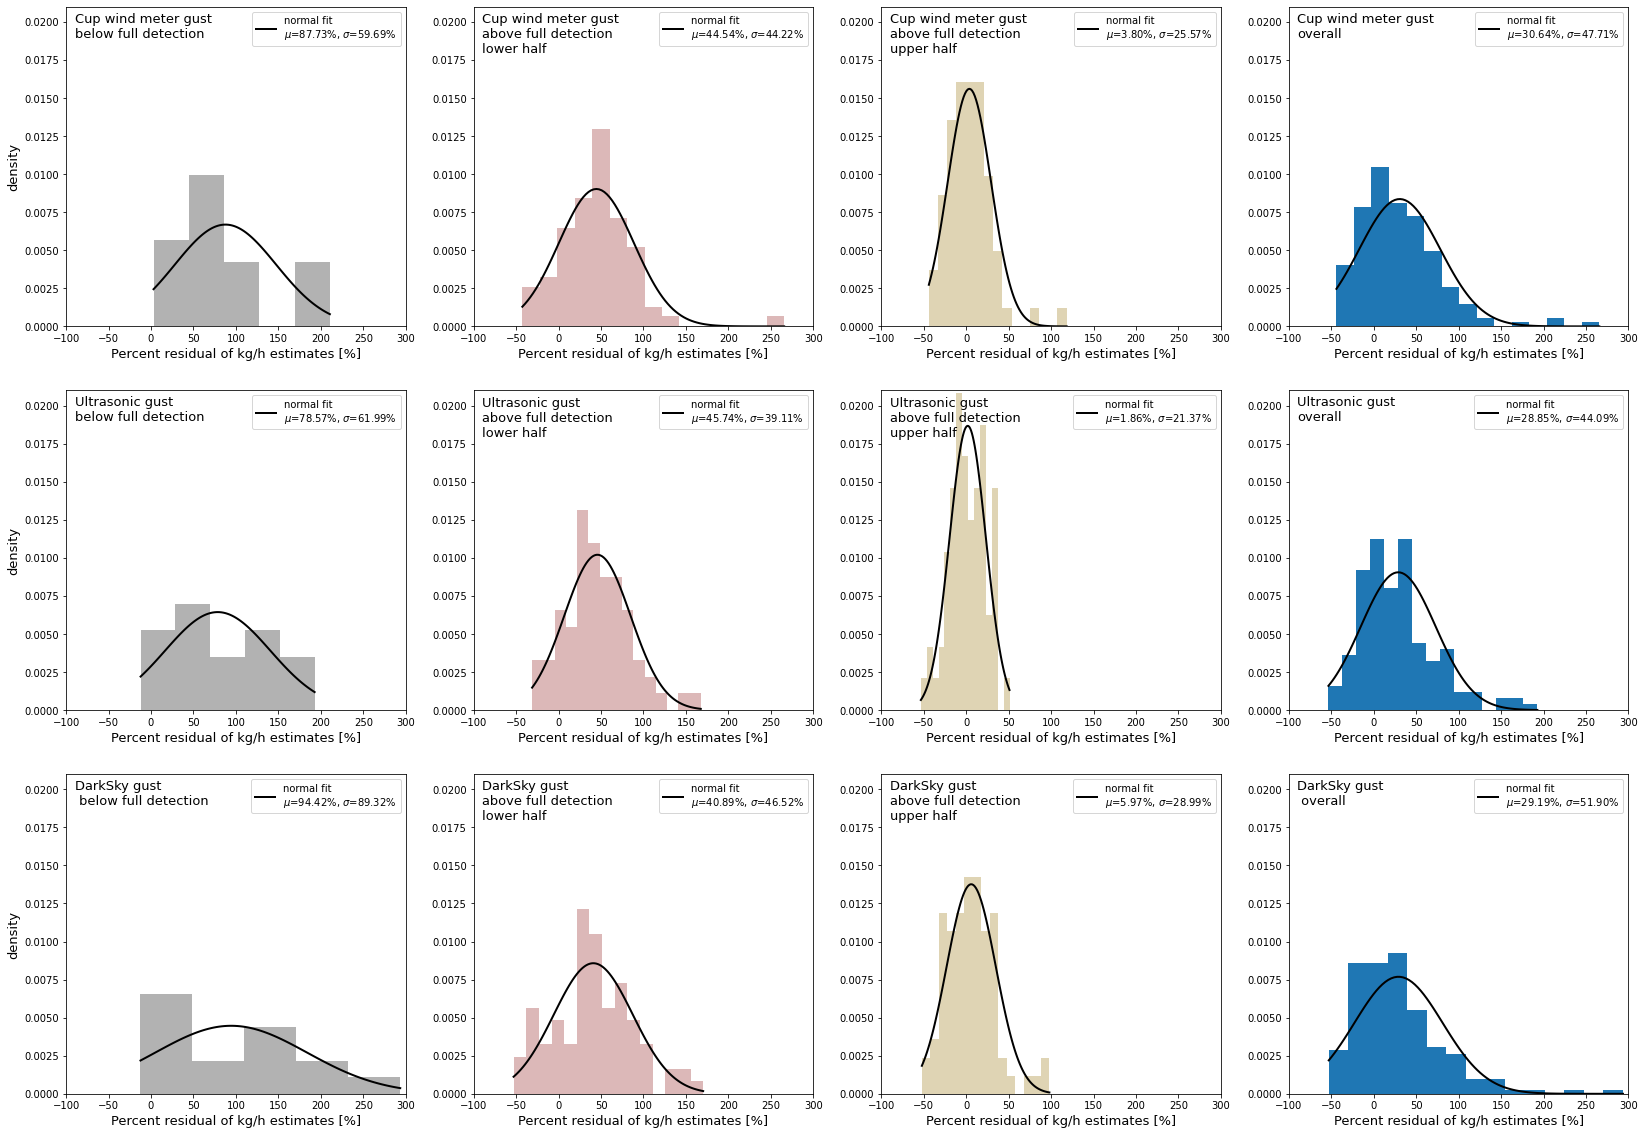

In [0]:
from scipy.stats import norm

full_detection_limit = 16   # kgh/mps methane over which 100% is detected

fig, ([[ax1,ax3,ax5,ax7],[ax2,ax4,ax6,ax8],[ax9,ax10,ax11,ax12]]) = plt.subplots(3,4,figsize=[28,20])
ax1.set_xlabel('Percent residual of kg/h estimates [%]',fontsize=13)
ax2.set_xlabel('Percent residual of kg/h estimates [%]',fontsize=13)
ax3.set_xlabel('Percent residual of kg/h estimates [%]',fontsize=13)
ax4.set_xlabel('Percent residual of kg/h estimates [%]',fontsize=13)
ax5.set_xlabel('Percent residual of kg/h estimates [%]',fontsize=13)
ax6.set_xlabel('Percent residual of kg/h estimates [%]',fontsize=13)
ax7.set_xlabel('Percent residual of kg/h estimates [%]',fontsize=13)
ax8.set_xlabel('Percent residual of kg/h estimates [%]',fontsize=13)
ax9.set_xlabel('Percent residual of kg/h estimates [%]',fontsize=13)
ax10.set_xlabel('Percent residual of kg/h estimates [%]',fontsize=13)
ax11.set_xlabel('Percent residual of kg/h estimates [%]',fontsize=13)
ax12.set_xlabel('Percent residual of kg/h estimates [%]',fontsize=13)
ax1.set_ylabel('density',fontsize=13)
ax2.set_ylabel('density',fontsize=13)
ax9.set_ylabel('density',fontsize=13)
ax1.set_xlim([-100,300]),ax2.set_xlim([-100,300]),ax1.set_ylim([0,0.021]),ax2.set_ylim([0,0.021])
ax3.set_xlim([-100,300]),ax4.set_xlim([-100,300]),ax3.set_ylim([0,0.021]),ax4.set_ylim([0,0.021])
ax5.set_xlim([-100,300]),ax6.set_xlim([-100,300]),ax5.set_ylim([0,0.021]),ax6.set_ylim([0,0.021])
ax7.set_xlim([-100,300]),ax8.set_xlim([-100,300]),ax7.set_ylim([0,0.021]),ax8.set_ylim([0,0.021])
ax9.set_xlim([-100,300]),ax11.set_xlim([-100,300]),ax9.set_ylim([0,0.021]),ax11.set_ylim([0,0.021])
ax10.set_xlim([-100,300]),ax12.set_xlim([-100,300]),ax10.set_ylim([0,0.021]),ax12.set_ylim([0,0.021])

ax1.annotate('Cup wind meter gust\nbelow full detection',[-90,0.019],fontsize=13)
ax2.annotate('Ultrasonic gust \nbelow full detection',[-90,0.019],fontsize=13)
ax3.annotate('Cup wind meter gust\nabove full detection\nlower half',[-90,0.018],fontsize=13)
ax4.annotate('Ultrasonic gust\nabove full detection\nlower half',[-90,0.018],fontsize=13)
ax5.annotate('Cup wind meter gust\nabove full detection\nupper half',[-90,0.018],fontsize=13)
ax6.annotate('Ultrasonic gust\nabove full detection\nupper half',[-90,0.018],fontsize=13)
ax7.annotate('Cup wind meter gust\noverall',[-90,0.019],fontsize=13)
ax8.annotate('Ultrasonic gust \noverall',[-90,0.019],fontsize=13)

ax9.annotate('DarkSky gust \n below full detection',[-90,0.019],fontsize=13)
ax10.annotate('DarkSky gust\nabove full detection\nlower half',[-90,0.018],fontsize=13)
ax11.annotate('DarkSky gust\nabove full detection\nupper half',[-90,0.018],fontsize=13)
ax12.annotate('DarkSky gust \n overall',[-90,0.019],fontsize=13)

################# cup wind meter #######################
# below min
plot_data = data_selection(data,'Base','WS_windGust_logged_mps')
plot_data = plot_data[plot_data.closest_plume_quantification_kgh!=0]
plot_data = plot_data[~np.isnan(plot_data.closest_plume_quantification_kgh)]
y = plot_data.CH4_release_kgh.values
x = plot_data.closest_plume_quantification_kgh
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)
y_pred = x*slope
percent_residual = residual/y_pred*100

df = pd.DataFrame()
df['x'] = x[x<full_detection_limit*plot_data.WS_windGust_logged_mps.median()]
df['y'] = percent_residual[x<full_detection_limit*plot_data.WS_windGust_logged_mps.median()]

ax1.hist(df.y, bins=5, density=True, color='k',alpha=0.3)
mu,std = norm.fit(df.y)
xmin, xmax = np.min(df.y), np.max(df.y)
xx = np.linspace(xmin, xmax, 100)
p = norm.pdf(xx, mu, std)
ax1.plot(xx, p, 'k', linewidth=2,label='normal fit \n$\mu$=%.2f%%, $\sigma$=%.2f%%'%(mu,std))
ax1.legend()

# above min lower half
df = pd.DataFrame()
df['x'] = x[x>=full_detection_limit*plot_data.WS_windGust_logged_mps.median()]
df['y'] = percent_residual[x>=full_detection_limit*plot_data.WS_windGust_logged_mps.median()]
df = df[df.x<df.x.median()]

ax3.hist(df.y, bins=15, density=True, color='#8c1515',alpha=0.3)
mu,std = norm.fit(df.y)
xmin, xmax = np.min(df.y), np.max(df.y)
xx = np.linspace(xmin, xmax, 100)
p = norm.pdf(xx, mu, std)
ax3.plot(xx, p, 'k', linewidth=2,label='normal fit \n$\mu$=%.2f%%, $\sigma$=%.2f%%'%(mu,std))
ax3.legend()

# above min upper half
df = pd.DataFrame()
df['x'] = x[x>=full_detection_limit*plot_data.WS_windGust_logged_mps.median()]
df['y'] = percent_residual[x>=full_detection_limit*plot_data.WS_windGust_logged_mps.median()]
df = df[df.x>=df.x.median()]

ax5.hist(df.y, bins=15, density=True, color='#D2C295',alpha=0.7)
mu,std = norm.fit(df.y)
xmin, xmax = np.min(df.y), np.max(df.y)
xx = np.linspace(xmin, xmax, 100)
p = norm.pdf(xx, mu, std)
ax5.plot(xx, p, 'k', linewidth=2,label='normal fit \n$\mu$=%.2f%%, $\sigma$=%.2f%%'%(mu,std))
ax5.legend()

# overall
df = pd.DataFrame()
df['x'] = x
df['y'] = percent_residual

ax7.hist(df.y, bins=15, density=True)
mu,std = norm.fit(df.y)
xmin, xmax = np.min(df.y), np.max(df.y)
xx = np.linspace(xmin, xmax, 100)
p = norm.pdf(xx, mu, std)
ax7.plot(xx, p, 'k', linewidth=2,label='normal fit \n$\mu$=%.2f%%, $\sigma$=%.2f%%'%(mu,std))
ax7.legend()

############# ultrasonic anemometer ########################
# below min
plot_data = data_selection(data,'Base','sonic_windGust_mps')
plot_data = plot_data[plot_data.closest_plume_quantification_kgh!=0]
plot_data = plot_data[~np.isnan(plot_data.closest_plume_quantification_kgh)]
y = plot_data.CH4_release_kgh.values
x = plot_data.closest_plume_quantification_kgh
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)
y_pred = x*slope
percent_residual = residual/y_pred*100

df = pd.DataFrame()
df['x'] = x[x<full_detection_limit*plot_data.sonic_windGust_mps.median()]
df['y'] = percent_residual[x<full_detection_limit*plot_data.sonic_windGust_mps.median()]

ax2.hist(df.y, bins=5, density=True, color='k',alpha=0.3)
mu,std = norm.fit(df.y)
xmin, xmax = np.min(df.y), np.max(df.y)
xx = np.linspace(xmin, xmax, 100)
p = norm.pdf(xx, mu, std)
ax2.plot(xx, p, 'k', linewidth=2,label='normal fit \n$\mu$=%.2f%%, $\sigma$=%.2f%%'%(mu,std))
ax2.legend()

# above min lower half
df = pd.DataFrame()
df['x'] = x[x>=full_detection_limit*plot_data.sonic_windGust_mps.median()]
df['y'] = percent_residual[x>=full_detection_limit*plot_data.sonic_windGust_mps.median()]
df = df[df.x<df.x.median()]

ax4.hist(df.y, bins=15, density=True, color='#8c1515',alpha=0.3)
mu,std = norm.fit(df.y)
xmin, xmax = np.min(df.y), np.max(df.y)
xx = np.linspace(xmin, xmax, 100)
p = norm.pdf(xx, mu, std)
ax4.plot(xx, p, 'k', linewidth=2,label='normal fit \n$\mu$=%.2f%%, $\sigma$=%.2f%%'%(mu,std))
ax4.legend()

# above min upper half
df = pd.DataFrame()
df['x'] = x[x>=full_detection_limit*plot_data.sonic_windGust_mps.median()]
df['y'] = percent_residual[x>=full_detection_limit*plot_data.sonic_windGust_mps.median()]
df = df[df.x>=df.x.median()]

ax6.hist(df.y, bins=15, density=True, color='#D2C295',alpha=0.7)
mu,std = norm.fit(df.y)
xmin, xmax = np.min(df.y), np.max(df.y)
xx = np.linspace(xmin, xmax, 100)
p = norm.pdf(xx, mu, std)
ax6.plot(xx, p, 'k', linewidth=2,label='normal fit \n$\mu$=%.2f%%, $\sigma$=%.2f%%'%(mu,std))
ax6.legend()

# overall
df = pd.DataFrame()
df['x'] = x
df['y'] = percent_residual

ax8.hist(df.y, bins=15, density=True)
mu,std = norm.fit(df.y)
xmin, xmax = np.min(df.y), np.max(df.y)
xx = np.linspace(xmin, xmax, 100)
p = norm.pdf(xx, mu, std)
ax8.plot(xx, p, 'k', linewidth=2,label='normal fit \n$\mu$=%.2f%%, $\sigma$=%.2f%%'%(mu,std))
ax8.legend()


############# DarkSky ########################
wind_to_use = 'darksky_windGust_mps'
# below min
plot_data = data_selection(data,'Base',wind_to_use)
plot_data = plot_data[plot_data.closest_plume_quantification_kgh!=0]
plot_data = plot_data[~np.isnan(plot_data.closest_plume_quantification_kgh)]
y = plot_data.CH4_release_kgh.values
x = plot_data.closest_plume_quantification_kgh
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)
y_pred = x*slope
percent_residual = residual/y_pred*100

df = pd.DataFrame()
df['x'] = x[x<full_detection_limit*plot_data[wind_to_use].median()]
df['y'] = percent_residual[x<full_detection_limit*plot_data[wind_to_use].median()]

ax9.hist(df.y, bins=5, density=True, color='k',alpha=0.3)
mu,std = norm.fit(df.y)
xmin, xmax = np.min(df.y), np.max(df.y)
xx = np.linspace(xmin, xmax, 100)
p = norm.pdf(xx, mu, std)
ax9.plot(xx, p, 'k', linewidth=2,label='normal fit \n$\mu$=%.2f%%, $\sigma$=%.2f%%'%(mu,std))
ax9.legend()

# above min lower half
df = pd.DataFrame()
df['x'] = x[x>=full_detection_limit*plot_data[wind_to_use].median()]
df['y'] = percent_residual[x>=full_detection_limit*plot_data[wind_to_use].median()]
df = df[df.x<df.x.median()]

ax10.hist(df.y, bins=15, density=True, color='#8c1515',alpha=0.3)
mu,std = norm.fit(df.y)
xmin, xmax = np.min(df.y), np.max(df.y)
xx = np.linspace(xmin, xmax, 100)
p = norm.pdf(xx, mu, std)
ax10.plot(xx, p, 'k', linewidth=2,label='normal fit \n$\mu$=%.2f%%, $\sigma$=%.2f%%'%(mu,std))
ax10.legend()

# above min upper half
df = pd.DataFrame()
df['x'] = x[x>=full_detection_limit*plot_data[wind_to_use].median()]
df['y'] = percent_residual[x>=full_detection_limit*plot_data[wind_to_use].median()]
df = df[df.x>=df.x.median()]

ax11.hist(df.y, bins=15, density=True, color='#D2C295',alpha=0.7)
mu,std = norm.fit(df.y)
xmin, xmax = np.min(df.y), np.max(df.y)
xx = np.linspace(xmin, xmax, 100)
p = norm.pdf(xx, mu, std)
ax11.plot(xx, p, 'k', linewidth=2,label='normal fit \n$\mu$=%.2f%%, $\sigma$=%.2f%%'%(mu,std))
ax11.legend()

# overall
df = pd.DataFrame()
df['x'] = x
df['y'] = percent_residual

ax12.hist(df.y, bins=15, density=True)
mu,std = norm.fit(df.y)
xmin, xmax = np.min(df.y), np.max(df.y)
xx = np.linspace(xmin, xmax, 100)
p = norm.pdf(xx, mu, std)
ax12.plot(xx, p, 'k', linewidth=2,label='normal fit \n$\mu$=%.2f%%, $\sigma$=%.2f%%'%(mu,std))
ax12.legend()


plt.show()
# plt.savefig(folder_path_graph+'SI Figures/'+'histagram_percent_residual'+fdate+'.pdf',format='pdf')

In [0]:
df.y.mean()

28.846680058994934

### wind avg

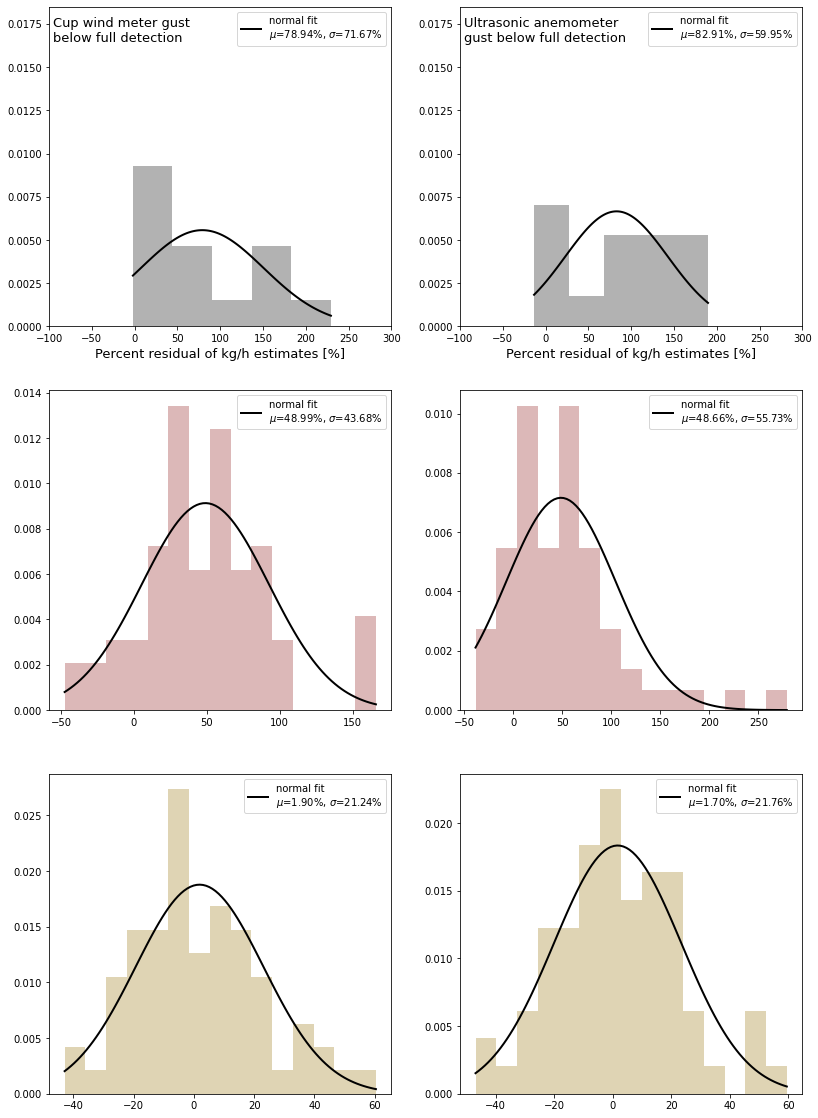

In [0]:
from scipy.stats import norm

full_detection_limit = 16   # kgh/mps methane over which 100% is detected

fig, ([[ax1,ax2],[ax3,ax4],[ax5,ax6]]) = plt.subplots(3,2,figsize=[13.5,20])
ax1.set_xlabel('Percent residual of kg/h estimates [%]',fontsize=13)
ax2.set_xlabel('Percent residual of kg/h estimates [%]',fontsize=13)
ax1.set_xlim([-100,300]),ax2.set_xlim([-100,300]),ax1.set_ylim([0,0.0185]),ax2.set_ylim([0,0.0185])
ax1.annotate('Cup wind meter gust\nbelow full detection',[-95,0.0165],fontsize=13)
ax2.annotate('Ultrasonic anemometer\ngust below full detection',[-95,0.0165],fontsize=13)

################# cup wind meter #######################
# below min
plot_data = data_selection(data,'Base','WS_windSpeed_mps')
plot_data = plot_data[plot_data.closest_plume_quantification_kgh!=0]
plot_data = plot_data[~np.isnan(plot_data.closest_plume_quantification_kgh)]
y = plot_data.CH4_release_kgh.values
x = plot_data.closest_plume_quantification_kgh
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)
y_pred = x*slope
percent_residual = residual/y_pred*100

df = pd.DataFrame()
df['x'] = x[x<full_detection_limit*plot_data.WS_windSpeed_mps.median()]
df['y'] = percent_residual[x<full_detection_limit*plot_data.WS_windSpeed_mps.median()]

ax1.hist(df.y, bins=5, density=True, color='k',alpha=0.3)
mu,std = norm.fit(df.y)
xmin, xmax = np.min(df.y), np.max(df.y)
xx = np.linspace(xmin, xmax, 100)
p = norm.pdf(xx, mu, std)
ax1.plot(xx, p, 'k', linewidth=2,label='normal fit \n$\mu$=%.2f%%, $\sigma$=%.2f%%'%(mu,std))
ax1.legend()

# above min lower half
df = pd.DataFrame()
df['x'] = x[x>=full_detection_limit*plot_data.WS_windSpeed_mps.median()]
df['y'] = percent_residual[x>=full_detection_limit*plot_data.WS_windSpeed_mps.median()]
df = df[df.x<df.x.median()]

ax3.hist(df.y, bins=15, density=True, color='#8c1515',alpha=0.3)
mu,std = norm.fit(df.y)
xmin, xmax = np.min(df.y), np.max(df.y)
xx = np.linspace(xmin, xmax, 100)
p = norm.pdf(xx, mu, std)
ax3.plot(xx, p, 'k', linewidth=2,label='normal fit \n$\mu$=%.2f%%, $\sigma$=%.2f%%'%(mu,std))
ax3.legend()

# above min upper half
df = pd.DataFrame()
df['x'] = x[x>=full_detection_limit*plot_data.WS_windSpeed_mps.median()]
df['y'] = percent_residual[x>=full_detection_limit*plot_data.WS_windSpeed_mps.median()]
df = df[df.x>=df.x.median()]

ax5.hist(df.y, bins=15, density=True, color='#D2C295',alpha=0.7)
mu,std = norm.fit(df.y)
xmin, xmax = np.min(df.y), np.max(df.y)
xx = np.linspace(xmin, xmax, 100)
p = norm.pdf(xx, mu, std)
ax5.plot(xx, p, 'k', linewidth=2,label='normal fit \n$\mu$=%.2f%%, $\sigma$=%.2f%%'%(mu,std))
ax5.legend()

############# ultrasonic anemometer ########################
# below min
plot_data = data_selection(data,'Base','sonic_windSpeed_mps')
plot_data = plot_data[plot_data.closest_plume_quantification_kgh!=0]
plot_data = plot_data[~np.isnan(plot_data.closest_plume_quantification_kgh)]
y = plot_data.CH4_release_kgh.values
x = plot_data.closest_plume_quantification_kgh
n,slope,r_squared,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(x,y)
y_pred = x*slope
percent_residual = residual/y_pred*100

df = pd.DataFrame()
df['x'] = x[x<full_detection_limit*plot_data.sonic_windSpeed_mps.median()]
df['y'] = percent_residual[x<full_detection_limit*plot_data.sonic_windSpeed_mps.median()]

ax2.hist(df.y, bins=5, density=True, color='k',alpha=0.3)
mu,std = norm.fit(df.y)
xmin, xmax = np.min(df.y), np.max(df.y)
xx = np.linspace(xmin, xmax, 100)
p = norm.pdf(xx, mu, std)
ax2.plot(xx, p, 'k', linewidth=2,label='normal fit \n$\mu$=%.2f%%, $\sigma$=%.2f%%'%(mu,std))
ax2.legend()

# above min lower half
df = pd.DataFrame()
df['x'] = x[x>=full_detection_limit*plot_data.sonic_windSpeed_mps.median()]
df['y'] = percent_residual[x>=full_detection_limit*plot_data.sonic_windSpeed_mps.median()]
df = df[df.x<df.x.median()]

ax4.hist(df.y, bins=15, density=True, color='#8c1515',alpha=0.3)
mu,std = norm.fit(df.y)
xmin, xmax = np.min(df.y), np.max(df.y)
xx = np.linspace(xmin, xmax, 100)
p = norm.pdf(xx, mu, std)
ax4.plot(xx, p, 'k', linewidth=2,label='normal fit \n$\mu$=%.2f%%, $\sigma$=%.2f%%'%(mu,std))
ax4.legend()

# above min upper half
df = pd.DataFrame()
df['x'] = x[x>=full_detection_limit*plot_data.sonic_windSpeed_mps.median()]
df['y'] = percent_residual[x>=full_detection_limit*plot_data.sonic_windSpeed_mps.median()]
df = df[df.x>=df.x.median()]

ax6.hist(df.y, bins=15, density=True, color='#D2C295',alpha=0.7)
mu,std = norm.fit(df.y)
xmin, xmax = np.min(df.y), np.max(df.y)
xx = np.linspace(xmin, xmax, 100)
p = norm.pdf(xx, mu, std)
ax6.plot(xx, p, 'k', linewidth=2,label='normal fit \n$\mu$=%.2f%%, $\sigma$=%.2f%%'%(mu,std))
ax6.legend()

plt.show()
# plt.savefig(folder_path_graph+'SI Figures/'+'histagram_percent_residual'+fdate+'.pdf',format='pdf')

# save functions and graphs
Run the following cells to save graphs and functions. Even if the main ipynb is saved, the changes made to the functions and the graphs generated will be lost if these cells are not executed.

In [0]:
import os
folder_to_save = 'drive/My Drive/Controlled Methane Release Stanford-Kairos Oct 2019/Elementa Submission/analysis/'

In [0]:
# functions
files_to_save = ['functions/data_processing.py','functions/min_detection.py']

for files in files_to_save:
  with open(os.path.join(folder_to_save+files), 'w') as f:
    f.write(folder_to_save.join(open(folder_to_save+files).readlines()))

In [0]:
# graphs
files_to_save = ['graphs_manuscript/'+'KairosDetectionThresholdCup'+fdate+'.pdf',
                 'graphs_manuscript/'+'KairosDetectionThresholdUltrasonic'+fdate+'.pdf']

for files in files_to_save:
  with open(os.path.join(folder_to_save+files), 'w') as f:
    f.write(folder_to_save.join(open(folder_to_save+files).readlines()))